# Introduction

For this final project, I decided to work on location dmata of Osaka, Japan, where I'm living.
Osaka is second largest city in Japan and there are a lot of shops and restaurant, but good restaurants are always full of people.
On the other hand, data shows that 30% of new restaurant or cafe goes bankrupt within a year, and 50% within 3 years. The reason of the high bankrupt rate is various, but location is one of most important factor, for example, there are too many similar shops, there is no demand for specific shops for residential area and so on. 
Since I love to have coffee at nice, cozy cafe for a break during work, I'm interested in analyzing location data of osaka, given I would open coffee shop.
The target is **area with less cafe** and **not residential but bussiness** oriented aera.

Research question ; Where is the best place to open coffee shop in Osaka, Japan?




# Data
To execute idea that categorize Osaka central city and find good place to open coffee shop, I used following 3 data sources.

## Data sources  

- **Forsqure API**  
As we learned it during this module, I used Forsqure location data via API.

- **Address**   
the list of Osaka neighborhoods are required. It is available in open data base. [http://jusyo.jp/csv/new.php]
This website provides all Japanese address with postal codes, and files are zipped for each prefecture.(Sorry, only Japanese are available!) I took only Osaka address using `wget` command. 

- **Geocoding**    
To get coordinates, I used [geocoorder](https://www.geocoding.jp/) API. It allows to get all latitude and longitude for given address.(Again, addresses are written in Japanese, sorry!)
This [reference](https://qiita.com/paulxll/items/7bc4a5b0529a8d784673) helped me to use the API.


## Get address 

First, let's get addresses of all Osaka area.

In [ ]:
!wget -q -O http://jusyo.jp/downloads/new/csv/csv_27osaka.zip

import zipfile
with zipfile.ZipFile('csv_27osaka.zip') as myzip:
    myzip.extract('27osaka.csv') 

In [87]:
import pandas as pd
import codecs
import numpy as np

In [88]:
# data are encorded with JIS, and 'pd.read_csv' doesn't work.
with codecs.open('27osaka.csv', "r", "Shift-JIS", "ignore") as file:
    df = pd.read_table(file, delimiter=",")
df = pd.DataFrame(df)

# drop specific office address
df = df[df['事業所名'].isna()]
df = df[['郵便番号', '市区町村','町域']]
df.columns = ['PostalCode','Borough','Neighborhood']

# limit to center of Osaka-city
df = df[df['Borough'].str.startswith('大阪市北区')|df['Borough'].str.startswith('大阪市中央区')|df['Borough'].str.startswith('大阪市福島区')|df['Borough'].str.startswith('大阪市都島区')]

# clean up
df['Address'] = df['Borough'] + df['Neighborhood']
df.drop_duplicates(subset=['Address'], inplace = True)
df.dropna(inplace = True)
df.reset_index(inplace = True, drop =True)

df.head()

,PostalCode,Borough,Neighborhood,Address
0,534-0026,大阪市都島区,網島町,大阪市都島区網島町
1,534-0013,大阪市都島区,内代町,大阪市都島区内代町
2,534-0025,大阪市都島区,片町,大阪市都島区片町
3,534-0001,大阪市都島区,毛馬町,大阪市都島区毛馬町
4,534-0015,大阪市都島区,善源寺町,大阪市都島区善源寺町


In [89]:
df.shape

(148, 4)

148 neighborhood's name was obtained. 

## Get coordinates 

To use forsqure API, we need longitude and latitude. I could get it through geocoder API


In [90]:
import requests
from bs4 import BeautifulSoup
import time

URL = 'http://www.geocoding.jp/api/'

def coordinate(address):
    payload = {'q': address}
    html = requests.get(URL, params=payload)
    soup = BeautifulSoup(html.content, "html.parser")
    if soup.find('error'):
        raise ValueError(f"Invalid address submitted. {address}")
    latitude = soup.find('lat').string
    longitude = soup.find('lng').string
    return [latitude, longitude]


def coordinates(addresses):
    coordinates = pd.DataFrame(columns = ['latitude','longitude','address'])
    coordinates.set_index('address',inplace = True)
    for address in addresses:
        try:
            coord = coordinate(address)
            coordinates.loc[address] = [coord[0],coord[1]]
        except:
            print(address)
        time.sleep(10)
    return coordinates

In [ ]:
osaka_address = df.Address.to_list()
osaka_coords = coordinates(osaka_address)

In [91]:
#save as csv so that I could use for exploring data 
#osaka_coords.to_csv('osaka_coords.csv', index = False)
osaka_coords = pd.read_csv('osaka_coords.csv')

In [92]:
print(osaka_coords.shape)
osaka_coords.head()

(148, 3)


,address,latitude,longitude
0,大阪市都島区網島町,34.695491,135.524609
1,大阪市都島区内代町,34.711172,135.538168
2,大阪市都島区片町,34.693780,135.528146
3,大阪市都島区毛馬町,34.723028,135.522840
4,大阪市都島区善源寺町,34.712168,135.524609


All 148 neighborhoods coordinates could be prepared.

## Get location data

Using forsqure API, get venue data.


In [93]:
import random 
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html
from pandas.io.json import json_normalize

import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Using Folium package, visualize addresses which I got on map.

In [94]:
# create map of osaka using latitude and longitude values
lat = osaka_coords[osaka_coords['address']=='大阪市北区西天満'].latitude
lon = osaka_coords[osaka_coords['address']=='大阪市北区西天満'].longitude
map_osaka = folium.Map(location=[lat, lon], zoom_start=14)

# add markers to map
for lat, lng, neighborhood in zip(osaka_coords['latitude'], osaka_coords['longitude'], osaka_coords['address']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_osaka)  
    
map_osaka

In [26]:
#Credential setting for foursqure developer API
CLIENT_ID = '4CXJVQTJNPBIFY5413VOP2WRVQK0EGJ400OOJI2QJU1HCBB4' # your Foursquare ID
CLIENT_SECRET = 'I3ECCDVCHAW2MDLJNISPQJYOU0ZYJGEK0CWECVOEYX1HWX5K' # your Foursquare Secret
ACCESS_TOKEN = 'CYCAIMSPDWIJBXNN5HVCNN5PBGZIMUHQFBTPG354MGFQ5EQ0' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
venues = getNearbyVenues(names=osaka_coords['address'],
                                   latitudes=osaka_coords['latitude'],
                                   longitudes=osaka_coords['longitude']
                                  )

In [28]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,大阪市都島区網島町,34.695491,135.524609,とん太,34.693324,135.526503,Tonkatsu Restaurant
1,大阪市都島区網島町,34.695491,135.524609,Fujita Museum (藤田美術館),34.695050,135.525421,Art Museum
2,大阪市都島区網島町,34.695491,135.524609,京橋Arc,34.694584,135.527113,Rock Club
3,大阪市都島区網島町,34.695491,135.524609,Mint Museum (造幣博物館),34.695739,135.521648,Museum
4,大阪市都島区網島町,34.695491,135.524609,藤田邸跡公園,34.695006,135.524321,Garden


In [29]:
print('Total ' + str(venues.shape[0])+ ' venues are found') 
print('There are {} unique categories'.format(len(venues['Venue Category'].unique())))

Total 4257 venues are found
There are 199 unique categories


Now, I have all data for my analysis.

# Exploratory data analysis

venues = getNearbyVenues(names=osaka_coords['address'],
                                   latitudes=osaka_coords['latitude'],
                                   longitudes=osaka_coords['longitude']
                                  )

In [2]:
venues = pd.read_csv('venues.csv')
venues.drop('Unnamed: 0', axis =1, inplace = True)
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,大阪市都島区網島町,34.695491,135.524609,とん太,34.693324,135.526503,Tonkatsu Restaurant
1,大阪市都島区網島町,34.695491,135.524609,Fujita Museum (藤田美術館),34.695050,135.525421,Art Museum
2,大阪市都島区網島町,34.695491,135.524609,京橋Arc,34.694584,135.527113,Rock Club
3,大阪市都島区網島町,34.695491,135.524609,Mint Museum (造幣博物館),34.695739,135.521648,Museum
4,大阪市都島区網島町,34.695491,135.524609,藤田邸跡公園,34.695006,135.524321,Garden


In [3]:
print('Total ' + str(venues.shape[0])+ ' venues are found') 
print('There are {} unique categories'.format(len(venues['Venue Category'].unique())))

Total 4257 venues are found
There are 199 unique categories


## Most common categories  

All venues are categorized like 'restaurant' in forsqure data. This `Venue Category` is most important for analysis as the venue name itself doesn't tell much. Let's have a look what kind of categories are common. 

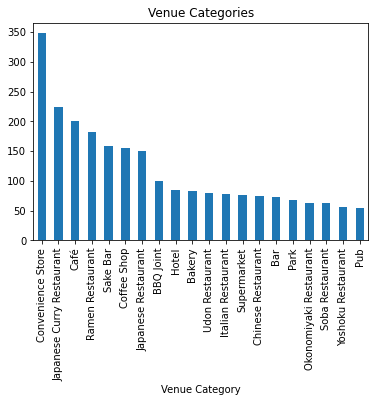

In [4]:
venue_count = venues.groupby('Venue Category').Venue.count()
venue_count.sort_values(ascending=False)
venues.value_counts('Venue Category')[:20].plot(kind = 'bar')
plt.title('Venue Categories')
plt.show()

Most common category is convenience store, as expected. The second one is a little surprise to me because 'Japanese Curry Restaurant' is not traditional style compared with 'Ramen' or 'Takoyaki' as Japanese 'fast food'. But surely there are a lot here, this record should be true. From next section, I examine some most common categories to characterize area.


**Duplicated record**  
I found that in forsquare database, many venues are assigned to near neighborhoods. The duplicated venues are close from all assigned neighbors. It is convenient for characterize neighborhoods, but make it difficult to make each neighborhoods statistics.  There was no resource to get unique neighborhoods for all venues, therefore I remove duplicated venues for statistics with name 'unq_venues', and use whole data set for clustering with name of 'venues'. 

In [5]:
unq_venues = venues[~venues.duplicated(subset = ['Venue','Venue Latitude','Venue Longitude'],keep  = 'last')]
print('Total ' + str(unq_venues.shape[0])+ 'unique venues are found') 
unq_venues.reset_index(inplace = True, drop = True)
unq_venues

Total 1495unique venues are found


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,大阪市都島区網島町,34.695491,135.524609,片町カフェ,34.692899,135.525415,Café
1,大阪市都島区網島町,34.695491,135.524609,7-Eleven (セブンイレブン 大阪片町店),34.694275,135.527288,Convenience Store
2,大阪市都島区網島町,34.695491,135.524609,7-Eleven (セブンイレブン 大阪東野田町4丁目店),34.697543,135.526523,Convenience Store
3,大阪市都島区網島町,34.695491,135.524609,GARB dressing,34.695506,135.529118,Italian Restaurant
4,大阪市都島区網島町,34.695491,135.524609,Osakajo-kitazume Station (大阪城北詰駅),34.694047,135.525827,Train Station
...,...,...,...,...,...,...,...
1490,大阪市中央区龍造寺町,34.677136,135.519451,東横イン 大阪谷四交差点,34.681053,135.517062,Bed & Breakfast
1491,大阪市中央区龍造寺町,34.677136,135.519451,兵部大輔大村益次郎卿殉難報國之碑,34.678577,135.521078,Monument / Landmark
1492,大阪市中央区龍造寺町,34.677136,135.519451,Lawson (ローソン 谷町五丁目店),34.677157,135.517380,Convenience Store
1493,大阪市中央区龍造寺町,34.677136,135.519451,FamilyMart (ファミリーマート 内久宝寺町三丁目店),34.679033,135.515329,Convenience Store


## Convenience store
There are no record about office or company building in forsquere, and it is no direct measure to find business area. One hint to estimate business area would be convenience stores density, because the more convenience store, the more office and entertainment places normally.

First check neighborhood where most crowded with convenience stores.


In [6]:
Conveni = unq_venues[unq_venues['Venue Category']== 'Convenience Store']
print('There are {} Convenience store'.format(Conveni.shape[0]))


There are 177 Convenience store


Top 10 Neighborhoods where the number of convenience store is large. For this purpose, I use not 'unique' venues, because one neighborhood has some convenience store in enough close distance.

In [7]:
Conveni = venues[venues['Venue Category']== 'Convenience Store']
print(Conveni.groupby('Neighborhood').Venue.count().sort_values(ascending=False)[0:10])
print('Average : {}'.format(Conveni.groupby('Neighborhood').Venue.count().mean()))

Neighborhood
大阪市都島区都島北通    12
大阪市都島区都島本通    10
大阪市都島区中野町     10
大阪市北区本庄東       9
大阪市北区大淀南       9
大阪市福島区玉川       9
大阪市北区天満橋       9
大阪市都島区善源寺町     8
大阪市北区大淀中       8
大阪市北区長柄西       8
Name: Venue, dtype: int64
Average : 4.64


On average, there are more than 4 convenience stores in each neighborhood. I would say it is a lot considering each neighborhood's are quite small in area. Let's check the highest convenience store nighborhood,'大阪市都島区都島本通', where have 10 stores.

In [8]:
cnvn = Conveni[Conveni['Neighborhood']=='大阪市都島区都島北通']

lat = cnvn.iloc[1]['Neighborhood Latitude']
lon = cnvn.iloc[1]['Neighborhood Longitude']
map_cnvn = folium.Map(location=[lat, lon], zoom_start=16)

# add markers to map
for lat, lng, Venue in zip(cnvn['Venue Latitude'], cnvn['Venue Longitude'], cnvn['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cnvn)  
    
map_cnvn

Folium has already a lot of location data (actually more informative than foresqure in this case) We can see that there are a large central hospital, restaurants, clinics and many small parking lots in this area. I assume that this is not entertainment area but there are many people coming and going. 

## Restaurant

Restaurants are also good indicator of residential or business area.   There are so many restaurant related category in forsqure. 

In [9]:
venues['Venue Category'][venues['Venue Category'].str.endswith('Restaurant')].unique()

array(['Tonkatsu Restaurant', 'Nabe Restaurant', 'Italian Restaurant',
       'Ramen Restaurant', 'Japanese Restaurant', 'Chinese Restaurant',
       'Asian Restaurant', 'Restaurant', 'Shabu-Shabu Restaurant',
       'Sushi Restaurant', 'Japanese Curry Restaurant',
       'Fast Food Restaurant', 'Donburi Restaurant',
       'Japanese Family Restaurant', 'Udon Restaurant',
       'Kaiseki Restaurant', 'Thai Restaurant', 'Indian Restaurant',
       'Yakitori Restaurant', 'Spanish Restaurant', 'Korean Restaurant',
       'Comfort Food Restaurant', 'Teishoku Restaurant',
       'Seafood Restaurant', 'Soba Restaurant', 'Tempura Restaurant',
       'Tapas Restaurant', 'Unagi Restaurant', 'Okonomiyaki Restaurant',
       'Yoshoku Restaurant', 'Kushikatsu Restaurant',
       'Mexican Restaurant', 'Brazilian Restaurant', 'Russian Restaurant',
       'French Restaurant', 'Malay Restaurant', 'Sri Lankan Restaurant',
       'Vietnamese Restaurant', 'American Restaurant',
       'Dumpling Restauran

Detail labeling above is almost no information, for example, there are 'Kushikatsu restaurant' and 'Yakitori restaurant', both are typical Japanese restaurant serving food and alcohol. Therefore, I decided to reduce number of restaurant category into 2. One is 'Izakaya', where mainly open dinner time and alcohol and people enjoy time with colleagues or friends over food and alcohol. The other is 'Fastfood' style, like hamburger or ramen, where people don't stay long time but just eat for lunch break or after work. Apparently this is not perfect categorization but should be more informative than as it is.

In [10]:
restaurant_cat = list(venues['Venue Category'][venues['Venue Category'].str.endswith('Restaurant')].unique())
# relabel 'Izakaya' - type restaurant as 0, the other as 1
restaurant_type = [0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,
                  1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0]
restaurant_dict = {}
for i in range(len(restaurant_cat)):
    restaurant_dict.update({restaurant_cat[i] : restaurant_type[i]})
    
venues['Venue Category'].replace(restaurant_dict, inplace = True)

There are still restaurant, which is not named with 'restaurant'. We relabel it in same manner

In [11]:
venues['Venue Category'].replace({'Pizza Place':1,
                                 'Steakhouse':0,
                                  'Takoyaki Place':0,
                                 'BBQ joint': 0,
                                  'BBQ Joint':0,
                                  'Wings Joint':1,
                                 'Noodle House':1,
                                 'Food Court' : 1,
                                 'Burger Joint' :1,
                                 'Bistro':0,
                                 'Snack Place' : 1,
                                 'Fried Chicken Joint' : 1,
                                 'Sandwich Place':1,
                                 'Buffet' :0}, inplace = True)

In [12]:
venues['Venue Category'].replace({0:'Izakaya', 1:'Fastfood'}, inplace = True)

In [13]:
unq_venues = venues[~venues.duplicated(subset = ['Venue','Venue Latitude','Venue Longitude'],keep  = 'last')]
unq_venues.reset_index(inplace = True, drop = True)
venue_count = unq_venues.groupby('Venue Category').Venue.count()
venue_count.sort_values(ascending=False)


Venue Category
Izakaya                    337
Fastfood                   244
Convenience Store          177
Café                        72
Coffee Shop                 46
                          ... 
Gift Shop                    1
Gastropub                    1
Fruit & Vegetable Store      1
Food & Drink Shop            1
Wine Shop                    1
Name: Venue, Length: 139, dtype: int64

Now we have 337 'Izakaya' style restaurant, which is almost double of convenience store's number. I assumed that the business area has more convenience stores and more fastfood. I simply check the trend of restanrant vs convenience store's number below. 

In [14]:
restran_conveni = unq_venues[(unq_venues['Venue Category']=='Izakaya')|(unq_venues['Venue Category']=='Fastfood')|(unq_venues['Venue Category']=='Convenience Store')]
restran_conveni = restran_conveni.groupby(['Neighborhood','Venue Category']).Venue.count()
restran_conveni = pd.DataFrame(restran_conveni).reset_index()
restran_conveni = restran_conveni.pivot(index= 'Neighborhood', columns = 'Venue Category', values = 'Venue')

<AxesSubplot:xlabel='Convenience Store', ylabel='Izakaya'>

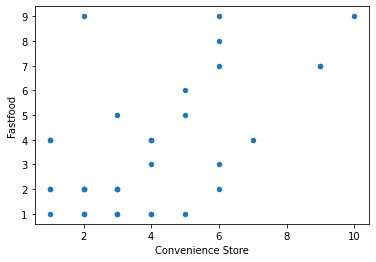

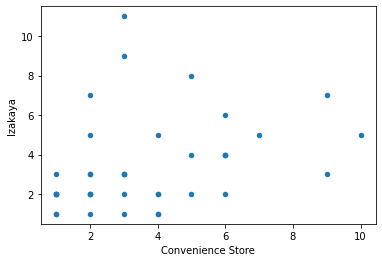

In [15]:
restran_conveni.plot(x= 'Convenience Store', y = 'Fastfood', kind = 'scatter')
restran_conveni.plot(x= 'Convenience Store', y = 'Izakaya', kind = 'scatter')

There is no clear trend, but seems the more convenience store and the fastfood shop, and both high number area would be our target. 

## Coffee shops
Most important information is the number of coffee shops around neighborhood as we look for less competitive area for it. The catergory 'Cafe' and 'Coffee shop' are actually same meaning in this data set. And like as restaurant, there are too many sweets shop category, I replace them as below.


In [16]:
venues['Venue Category'].replace({'Donut Shop':'Dessert Shop',
                                 'Ice Cream Shop':'Dessert Shop',
                                  'Pastry Shop':'Dessert Shop',
                                  'Chocolate Shop' : 'Dessert Shop',
                                  'Wagashi Place' :'Dessert Shop',
                                  'Gelato Shop' : 'Dessert Shop',
                                  'Creperie':'Dessert Shop',
                                 'Café' : 'Cafe',
                                  'Bubble Tea Shop':'Cafe',
                                  'Coffee Shop':'Cafe',
                                  'Tea Room' :'Cafe'
                                 }, inplace = True)
unq_venues = venues[~venues.duplicated(subset = ['Venue','Venue Latitude','Venue Longitude'],keep  = 'last')]
unq_venues.reset_index(inplace = True, drop = True)

In [17]:
Cafe = unq_venues[unq_venues['Venue Category']== 'Cafe']
print('There are {} Cafe store in total'.format(Cafe.shape[0]))

There are 122 Cafe store in total


In [18]:
Cafe = venues[venues['Venue Category']== 'Cafe']
print(Cafe.groupby('Neighborhood').Venue.count().sort_values(ascending=False)[0:20])
print('Average : {}'.format(Cafe.groupby('Neighborhood').Venue.count().mean()))

Neighborhood
大阪市北区菅原町     8
大阪市北区天神西町    8
大阪市中央区北浜     8
大阪市中央区今橋     7
大阪市北区中崎      7
大阪市北区浮田      7
大阪市北区西天満     6
大阪市中央区博労町    6
大阪市中央区備後町    6
大阪市北区茶屋町     6
大阪市北区鶴野町     6
大阪市中央区本町     5
大阪市北区中崎西     5
大阪市中央区城見     5
大阪市中央区南船場    5
大阪市北区角田町     5
大阪市北区大深町     5
大阪市中央区淡路町    5
大阪市中央区大阪城    4
大阪市北区梅田      4
Name: Venue, dtype: int64
Average : 2.975806451612903


In [19]:
cnvn = Cafe[Cafe['Neighborhood']=='大阪市北区菅原町']

lat = cnvn.iloc[1]['Neighborhood Latitude']
lon = cnvn.iloc[1]['Neighborhood Longitude']
map_cnvn = folium.Map(location=[lat, lon], zoom_start=16)

# add markers to map
for lat, lng, Venue in zip(cnvn['Venue Latitude'], cnvn['Venue Longitude'], cnvn['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cnvn)  
    
map_cnvn

It is river side place with green. That would be the reason of a lot of cafes. We have to avoid this neighborhood as high competitive, and the others high cafe density areas as well.

*****
# Clustering 

There are many other categories to characterize area, now we perform clustering using machine learning method, K-means, as it is effective for large data set and very intuitive. To execute clustering data needs to be cleaned and transformed. 

## Data cleaning 
There are a lot of small venue categories. Like we did in restaurant section, some categories are merged to make it more informative.

**Bars**  
Any kind of bar, e.g. 'Sake bar' or 'Wine bar' is merged into 'Bar'

In [20]:
venues['Venue Category'][venues['Venue Category'].str.endswith('Bar')].unique()

array(['Sake Bar', 'Beer Bar', 'Bar', 'Wine Bar', 'Juice Bar',
       'Whisky Bar', 'Hotel Bar', 'Hookah Bar', 'Cocktail Bar'],
      dtype=object)

In [22]:
venues.loc[venues[venues['Venue Category'].str.endswith('Bar')].index,'Venue Category'] = 'Bar'
venues['Venue Category'].replace({'Jazz Club':'Club',
                                  'Rock Club':'Club',
                                  'Nightclub':'Club',
                                  'Gastropub':'Bar',
                                 'Pub':'Bar'}, inplace = True)
                                  

**Museums**  
Art / science / History museums are merged.

In [23]:
print(venues['Venue Category'][venues['Venue Category'].str.endswith('Museum')].unique())
venues.loc[venues[venues['Venue Category'].str.endswith('Museum')].index,'Venue Category'] = 'Museum'

['Art Museum' 'Museum' 'Science Museum' 'History Museum']


**Sports facility**  
There are lots of sports related big facility like tennis court. We can merge them.

In [24]:
venues['Venue Category'].replace({'Golf Course':'Sports',
                                 'Tennis Court':'Sports',
                                   'Pool':'Sports',
                                  'Soccer Field':'Sports',
                                 'Baseball Field':'Sports',
                                 'Indoor Play Area':'Sports',
                                 'Golf Driving Range':'Sports'}, inplace = True)

**Inconsistent names**  
There are inconsistent categories, which we can merge.

In [25]:
venues['Venue Category'].replace({'Grocery Store':'Supermarket',
                                 'Discount Store':'Supermarket',
                                   'Food & Drink Shop':'Food Shop',
                                  'Food':'Food Shop',
                                  'Butcher':'Food Shop',
                                  'Farmers Market':'Food Shop',
                                  'Gourmet Shop':'Food Shop',
                                  'Fruit & Vegetable Store':'Food Shop',
                                 'Record Shop' : 'Hobby Shop',
                                 'Video Store' : 'Hobby Shop',
                                  'Toy / Game Store' : 'Hobby Shop',
                                 'Bed & Breakfast':'Hostel',
                                 'Gym / Fitness Center':'Gym',
                                  'Climbing Gym':'Gym',
                                  'Cycle Studio':'Gym',
                                 'Shopping Plaza':'Shopping mall',
                                 'Botanical Garden' : 'Garden',
                                 'Boutique' : 'Clothing Store',
                                  'Thrift / Vintage Store':'Clothing Store',
                                 'Opera House':'Theater',
                                 'Hot Spring':'Public Bath',
                                 'Bath House':'Public Bath',
                                  'Spa':'Public Bath',
                                 'Outdoor Sculpture':'Monument',
                                  'Monument / Landmark':'Monument',
                                 'Playground':'Garden',
                                 'Metro Station':'Train Station',
                                 'Camera Store':'Electronics Store',
                                 'Paper / Office Supplies Store':'Stationery Store'}, inplace = True)

**Drop category with too many missing data**  
There are some category which should be a lot of places in osaka area, but only few of them are recorded, e.g. intersections and bus stops. I decided to drop thoes incomplete categories.

In [26]:
venues[venues['Venue Category'].str.contains("Intersection|Bus Stop|ATM|Bridge|Bus Station|Toll Plaza|Platform|Mobile Phone Shop")].groupby('Venue Category').Venue.count()

Venue Category
ATM                   3
Bridge                1
Bus Station           1
Bus Stop             14
Intersection         14
Mobile Phone Shop     1
Platform              4
Toll Plaza            1
Name: Venue, dtype: int64

In [27]:
venues = venues[~(venues['Venue Category'].str.contains("Intersection|Bus Stop|ATM|Bridge|Bus Station|Toll Plaza|Platform|Mobile Phone Shop"))]

**Unknown/not relevant category**

In [28]:
venues[venues['Venue Category'].str.contains("Tree|Moving Target|IT Services|Trail|Well|Pier|Vape Store")].groupby('Venue Category').Venue.count()

Venue Category
IT Services      2
Moving Target    1
Pier             3
Trail            2
Tree             2
Vape Store       1
Well             3
Name: Venue, dtype: int64

In [29]:
venues = venues[~(venues['Venue Category'].str.contains("Tree|Moving Target|IT Services|Trail|Well|Pier|Vape Store"))]

venue_count = venues.groupby('Venue Category').Venue.count()
venue_count.sort_values(ascending=True)[1:50]

## Transform data

In [31]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Arcade,Art Gallery,Arts & Crafts Store,Baby Store,Bakery,Bar,Beer Garden,Bike Shop,Bookstore,...,Shopping mall,Sporting Goods Shop,Sports,Stationery Store,Supermarket,TV Station,Theater,Train Station,Wedding Hall,Wine Shop
0,大阪市中央区上本町西,0.000000,0.0,0.0,0.000000,0.066667,0.066667,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.133333,0.0,0.000000,0.000000,0.0,0.0
1,大阪市中央区上汐,0.000000,0.0,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.0,0.0
2,大阪市中央区上町,0.000000,0.0,0.0,0.000000,0.037037,0.037037,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.111111,0.0,0.000000,0.000000,0.0,0.0
3,大阪市中央区中寺,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.033333,0.0,0.033333,0.000000,0.0,0.0
4,大阪市中央区久太郎町,0.000000,0.0,0.0,0.033333,0.033333,0.066667,0.0,0.0,0.033333,...,0.0,0.0,0.000000,0.033333,0.033333,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,大阪市都島区都島中通,0.000000,0.0,0.0,0.000000,0.000000,0.052632,0.0,0.0,0.000000,...,0.0,0.0,0.052632,0.000000,0.105263,0.0,0.000000,0.000000,0.0,0.0
144,大阪市都島区都島北通,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.100000,0.0,0.000000,0.000000,0.0,0.0
145,大阪市都島区都島南通,0.033333,0.0,0.0,0.000000,0.000000,0.200000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.133333,0.0,0.000000,0.033333,0.0,0.0
146,大阪市都島区都島本通,0.000000,0.0,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0


In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,大阪市中央区上本町西,Fastfood,Convenience Store,Supermarket,Izakaya,Bakery,Bar,Cafe,Dessert Shop,Food Shop,Pharmacy
1,大阪市中央区上汐,Fastfood,Izakaya,Cafe,Supermarket,Hostel,Convenience Store,Dessert Shop,Bar,Drugstore,Clothing Store
2,大阪市中央区上町,Convenience Store,Izakaya,Cafe,Supermarket,Fastfood,Park,Food Shop,Dessert Shop,Monument,Bakery
3,大阪市中央区中寺,Fastfood,Izakaya,Convenience Store,Hostel,Cafe,Dessert Shop,Theater,Supermarket,Club,Pet Café
4,大阪市中央区久太郎町,Izakaya,Fastfood,Cafe,Bar,Hotel,Club,Baby Store,Bookstore,Supermarket,Stationery Store


## Clustering

In [51]:
# set number of clusters
kclusters = 5

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 4, 4, 4, 4, 1, 0])

In [52]:
osaka_coords = pd.read_csv('osaka_coords.csv')
osaka_coords[osaka_coords['address']=='大阪市北区西天満']

,address,latitude,longitude
64,大阪市北区西天満,34.696001,135.505161


In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

osaka_coords.columns = ['Neighborhood','latitude','longitude']
kmean_merged = osaka_coords.set_index('Neighborhood')

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
kmean_merged = kmean_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner')

kmean_merged.head() # check the last columns!from scipy.spatial import distance_matrix 


,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,
大阪市都島区網島町,34.695491,135.524609,1,Izakaya,Convenience Store,Cafe,Museum,Fastfood,Train Station,Wedding Hall,Bar,Supermarket,Bridal Shop
大阪市都島区内代町,34.711172,135.538168,1,Izakaya,Supermarket,Convenience Store,Fastfood,Shopping Mall,Motorcycle Shop,Hobby Shop,Park,Furniture / Home Store,Pharmacy
大阪市都島区片町,34.693780,135.528146,2,Izakaya,Bar,Cafe,Fastfood,Hobby Shop,Garden,Convenience Store,Concert Hall,Gym,Club
大阪市都島区毛馬町,34.723028,135.522840,1,Izakaya,Convenience Store,Fastfood,Supermarket,Pharmacy,Hobby Shop,Shipping Store,Drugstore,Park,Pet Café
大阪市都島区善源寺町,34.712168,135.524609,1,Convenience Store,Fastfood,Izakaya,Park,Supermarket,Cafe,Drugstore,Dessert Shop,Music Venue,Performing Arts Venue


In [61]:
# create map
lat = osaka_coords[osaka_coords['Neighborhood']=='大阪市北区西天満'].latitude
lon = osaka_coords[osaka_coords['Neighborhood']=='大阪市北区西天満'].longitude
map_clusters = folium.Map(location=[lat, lon], zoom_start=14)


# add markers to the map
markers_colors = ['#8000ff',# parple
                  '#1996f3',# blue
                  '#ff4dff',# pink 
                  '#00ff00',# light green
                  '#ff964f']# Orange]
                  
for lat, lon, poi, cluster in zip(kmean_merged['latitude'], kmean_merged['longitude'], kmean_merged.index, kmean_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster-1],
        fill=True,
        fill_color=markers_colors[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [ ]:
kmean_merged.loc[kmean_merged['Cluster Labels'] == 0, kmean_merged.columns[ list(range(3, kmean_merged.shape[1]))]]

In [ ]:
kmean_merged.loc[kmean_merged['Cluster Labels'] == 1, kmean_merged.columns[ list(range(3, kmean_merged.shape[1]))]]

In [ ]:
kmean_merged.loc[kmean_merged['Cluster Labels'] == 2, kmean_merged.columns[ list(range(3, kmean_merged.shape[1]))]]

In [ ]:
kmean_merged.loc[kmean_merged['Cluster Labels'] == 3, kmean_merged.columns[ list(range(3, kmean_merged.shape[1]))]]

In [ ]:
kmean_merged.loc[kmean_merged['Cluster Labels'] == 4, kmean_merged.columns[ list(range(3, kmean_merged.shape[1]))]]

**Cluster 0 (orange)**

- Mainly located along 'Tenjin-bashi' arcade, which is famous for longest arcade in japan with lots of Izakaya style restaurant
- Most of the neighborhoods have fastfood as most common venue.


**Cluster 1 (purple)**

- relatively outside of central Osaka.  
- It seems more residential area due to gym and supermarket.

**Cluster 2 (blue)**
- Surrounding Osaka station (the central station)
- a lot of entertainment places, like theaters and shopping malls.

**Cluster 3 (pink)**
- Only category which has less fastfood and Izakaya.
- It seems touristic place due to monuments, historic site, garden and museums.

**Cluster 4 (light green)**
- Middle part of Osaka area..
- Many cafe, Izakaya and fastfood. followed by Hotels. This are seems most business oriented.



****

# Result and Discussion

From the result of clustering, I assume that cluster 4 area is most business oriented and where we are targeting to open cafe. This area contains 37 neighborhoods.
Among them, we want to pick up neighborhoods which has less cafe. 

In [83]:
targets = kmean_merged[kmean_merged['Cluster Labels'] == 4].index
Cafe.query('Neighborhood in @targets').groupby('Neighborhood').Venue.count().sort_values()

Neighborhood
大阪市北区芝田        2
大阪市中央区西心斎橋     2
大阪市中央区宗右衛門町    2
大阪市中央区心斎橋筋     2
大阪市中央区東心斎橋     2
大阪市中央区石町       3
大阪市北区中之島       3
大阪市中央区北久宝寺町    3
大阪市北区万歳町       3
大阪市中央区高麗橋      3
大阪市中央区高津       3
大阪市中央区道頓堀      3
大阪市中央区道修町      3
大阪市中央区本町橋      3
大阪市北区天満        4
大阪市中央区船場中央     4
大阪市中央区久太郎町     4
大阪市中央区安土町      4
大阪市中央区天満橋京町    4
大阪市中央区伏見町      4
大阪市中央区南本町      4
大阪市中央区南久宝寺町    4
大阪市中央区東高麗橋     4
大阪市中央区淡路町      5
大阪市中央区南船場      5
大阪市北区大深町       5
大阪市北区中崎西       5
大阪市北区茶屋町       6
大阪市中央区備後町      6
大阪市中央区博労町      6
大阪市北区西天満       6
大阪市北区鶴野町       6
大阪市北区浮田        7
大阪市中央区今橋       7
大阪市北区天神西町      8
大阪市北区菅原町       8
大阪市中央区北浜       8
Name: Venue, dtype: int64

From above neighborhoods list, '北区芝田','中央区西心斎橋','中央区宗右衛門町','中央区心斎橋筋', and '中央区東心斎橋', have only 2 cafes each. That would be our final target.

# Conclusion

In this study, I analyzed Osaka location data to find the best place to open cafe. I used forsqure API and geocord data to get all required information, and explore Osaka venues. The target character of area was business area with less competitive (less cafe). First I examine whole data set and cleaned data to make the best use of it.
Then I used K-mean clustering, because it is very useful to categorize large number of data points, in this case I categorize 177 neighborhoods into 5 group. Finally I select one category which is more business oriented, and decide 5 neighborhoods which simply have less cafe.  